In [130]:
import os
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import torch
from models.ResUNet import ResUNet

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load in Test Data

In [131]:
data_path = '/mnt/WD6TB/tianaoli/dataset/SkinVessel_PACT/test/'
idx = 10022
gt = torch.from_numpy(np.load(os.path.join(data_path, 'gt', f"gt_{idx}.npy"))).float()
obs = torch.from_numpy(np.load(os.path.join(data_path, 'obs', f"obs_{idx}.npy"))).float()

### Load the Model

In [132]:
model = ResUNet(in_nc=8, out_nc=1)
pretrained_epochs = 38
loss = 'MSE'
pretrained_file = os.path.join('../saved_models/', f'ResUNet_{loss}_{pretrained_epochs}epochs.pth')
model.load_state_dict(torch.load(pretrained_file, map_location=torch.device(device)))
print('Successfully loaded in %s.', pretrained_file)

Successfully loaded in %s. ../saved_models/ResUNet_MSE_38epochs.pth


### Deconvolution

In [133]:
model.eval()
rec = model(obs)
rec = rec.squeeze(0).detach().numpy()
print(rec.shape)

(128, 128)


(-0.5, 127.5, 127.5, -0.5)

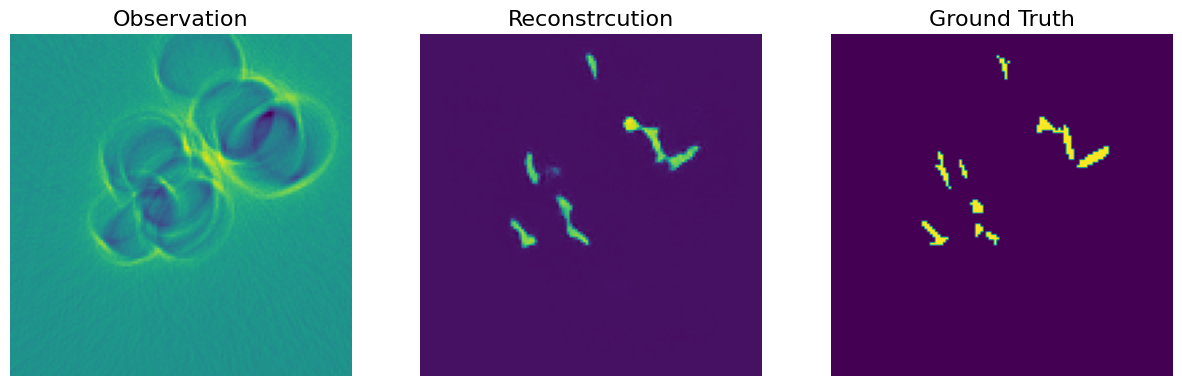

In [134]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.imshow(obs[3])
plt.title('Observation', fontsize=16)
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(rec)
plt.title('Reconstrcution', fontsize=16)
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(gt)
plt.title('Ground Truth', fontsize=16)
plt.axis('off')